# ML PIPELINE FOR WARFARINE DOSE PREDICTION

# Step 1: Import Required Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import joblib


# Step 2: Load Dataset

In [ ]:
file_path = '/content/drive/My Drive/CSCI-ML/Final Project/WARFARIN_DATA.xls'
df = pd.read_excel(file_path)

df.head()


,PharmGKB Subject ID,PharmGKB Sample ID,Project Site,Gender,Race (Reported),Race (OMB),Ethnicity (Reported),Ethnicity (OMB),Age,Height (cm),...,VKORC1 QC genotype: -4451 C>A (861); Chr16:31018002; rs17880887; A/C,CYP2C9 consensus,VKORC1 -1639 consensus,VKORC1 497 consensus,VKORC1 1173 consensus,VKORC1 1542 consensus,VKORC1 3730 consensus,VKORC1 2255 consensus,VKORC1 -4451 consensus,Comments regarding Project Site Dataset
0,PA135312261,PA135312629,1,male,White,White,not Hispanic or Latino,not Hispanic or Latino,60 - 69,193.040,...,NaN,*1/*1,A/G,G/T,NaN,C/G,A/G,NaN,NaN,Project 1:
1,PA135312262,PA135312630,1,female,White,White,not Hispanic or Latino,not Hispanic or Latino,50 - 59,176.530,...,C/C,*1/*1,A/A,G/T,T/T,C/C,G/G,T/T,C/C,Warfarin Therapeutic Dose Definition:
2,PA135312263,PA135312631,1,female,White,White,not Hispanic or Latino,not Hispanic or Latino,40 - 49,162.560,...,NaN,*1/*1,G/G,T/T,NaN,G/G,A/G,NaN,NaN,The dose (unchanged for 6 days) that yielded a...
3,PA135312264,PA135312632,1,male,White,White,not Hispanic or Latino,not Hispanic or Latino,60 - 69,182.245,...,NaN,*1/*1,A/G,G/T,NaN,C/G,G/G,NaN,NaN,NaN
4,PA135312265,PA135312633,1,male,White,White,not Hispanic or Latino,not Hispanic or Latino,50 - 59,167.640,...,NaN,*1/*3,A/G,T/T,NaN,C/G,A/G,NaN,NaN,NaN


# Step 3: Data Cleaning and Preprocessing

In [ ]:
# Check all columns to verify available ones
print(df.columns.tolist())


['PharmGKB Subject ID', 'PharmGKB Sample ID', 'Project Site', 'Gender', 'Race (Reported)', 'Race (OMB)', 'Ethnicity (Reported)', 'Ethnicity (OMB)', 'Age', 'Height (cm)', 'Weight (kg)', 'Indication for Warfarin Treatment', 'Comorbidities', 'Diabetes', 'Congestive Heart Failure and/or Cardiomyopathy', 'Valve Replacement', 'Medications', 'Aspirin', 'Acetaminophen or Paracetamol (Tylenol)', 'Was Dose of Acetaminophen or Paracetamol (Tylenol) >1300mg/day', 'Simvastatin (Zocor)', 'Atorvastatin (Lipitor)', 'Fluvastatin (Lescol)', 'Lovastatin (Mevacor)', 'Pravastatin (Pravachol)', 'Rosuvastatin (Crestor)', 'Cerivastatin (Baycol)', 'Amiodarone (Cordarone)', 'Carbamazepine (Tegretol)', 'Phenytoin (Dilantin)', 'Rifampin or Rifampicin', 'Sulfonamide Antibiotics', 'Macrolide Antibiotics', 'Anti-fungal Azoles', 'Herbal Medications, Vitamins, Supplements', 'Target INR', 'Estimated Target INR Range Based on Indication', 'Subject Reached Stable Dose of Warfarin', 'Therapeutic Dose of Warfarin', 'INR on

In [ ]:
# Relevant columns selection
required_cols = [
    'Gender', 'Race (Reported)', 'Age', 'Height (cm)', 'Weight (kg)',
    'Diabetes', 'Simvastatin (Zocor)', 'Amiodarone (Cordarone)',
    'Target INR', 'INR on Reported Therapeutic Dose of Warfarin',
    'CYP2C9 consensus', 'VKORC1 -1639 consensus', 'Therapeutic Dose of Warfarin'
]

# Subset the dataframe
df = df[required_cols]

# Rename columns for simplicity
df = df.rename(columns={
    'Gender': 'Gender',
    'Race (Reported)': 'Race',
    'Age': 'Age',
    'Height (cm)': 'Height',
    'Weight (kg)': 'Weight',
    'Diabetes': 'Diabetes',
    'Simvastatin (Zocor)': 'Simvastatin',
    'Amiodarone (Cordarone)': 'Amiodarone',
    'Target INR': 'Target_INR',
    'INR on Reported Therapeutic Dose of Warfarin': 'INR_Therapeutic',
    'CYP2C9 consensus': 'Cyp2C9',
    'VKORC1 -1639 consensus': 'VKORC1',
    'Therapeutic Dose of Warfarin': 'Dose'
})

# View the cleaned dataframe
df.head()



,Gender,Race,Age,Height,Weight,Diabetes,Simvastatin,Amiodarone,Target_INR,INR_Therapeutic,Cyp2C9,VKORC1,Dose
0,male,White,60 - 69,193.040,115.7,NaN,0.0,0.0,2.5,2.60,*1/*1,A/G,49.0
1,female,White,50 - 59,176.530,144.2,NaN,0.0,0.0,2.5,2.15,*1/*1,A/A,42.0
2,female,White,40 - 49,162.560,77.1,NaN,0.0,0.0,2.5,1.90,*1/*1,G/G,53.0
3,male,White,60 - 69,182.245,90.7,NaN,0.0,0.0,2.5,2.40,*1/*1,A/G,28.0
4,male,White,50 - 59,167.640,72.6,NaN,0.0,0.0,2.5,1.90,*1/*3,A/G,42.0


In [ ]:
#Handle Missing Values
df.replace(['NA', 'nan', -99], np.nan, inplace=True)

# Numerical columns → median imputation
numeric_cols = ['Height', 'Weight', 'INR_Therapeutic']
df[numeric_cols] = df[numeric_cols].astype(float).fillna(df[numeric_cols].median())

# Categorical columns → mode imputation
categorical_cols = ['Gender', 'Race', 'Age', 'Diabetes', 'Simvastatin', 'Amiodarone', 'Target_INR', 'Cyp2C9', 'VKORC1']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

#Encode Categorical Variables (One-Hot)
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

#Scale Numerical Features
scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])



# Step 4: Exploratory Data Analysis (EDA)

Text(0, 0.5, 'Frequency')

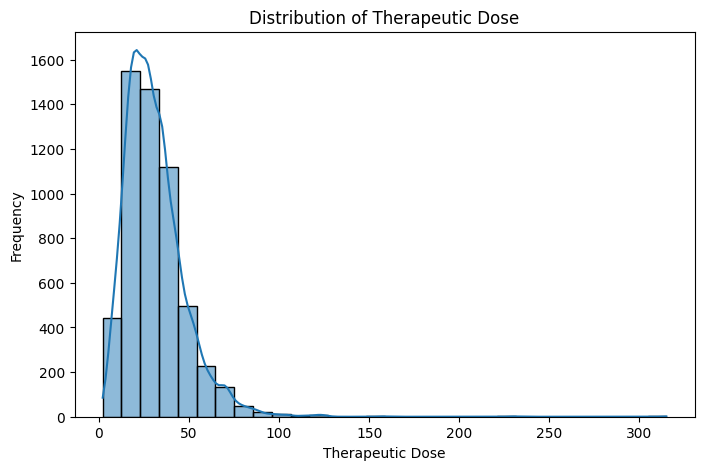

In [ ]:
#Distribution of Therapeutic Dose
plt.figure(figsize=(8, 5))
sns.histplot(df_encoded['Dose'], bins=30, kde=True)
plt.title('Distribution of Therapeutic Dose')
plt.xlabel('Therapeutic Dose')
plt.ylabel('Frequency')

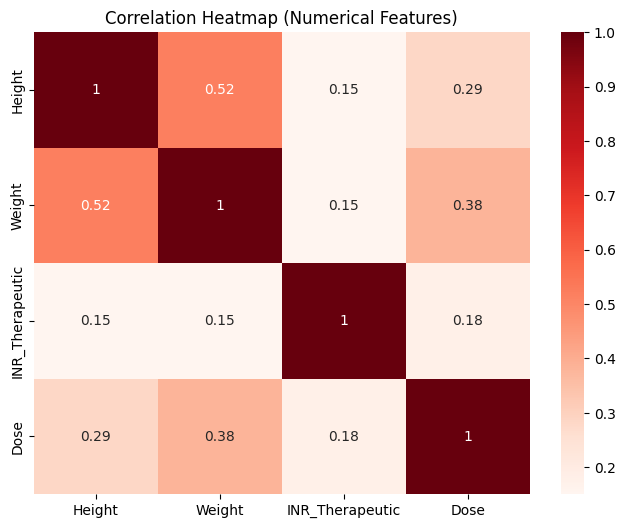

In [ ]:
#Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[['Height', 'Weight', 'INR_Therapeutic', 'Dose']].corr(), annot=True, cmap='Reds')
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()


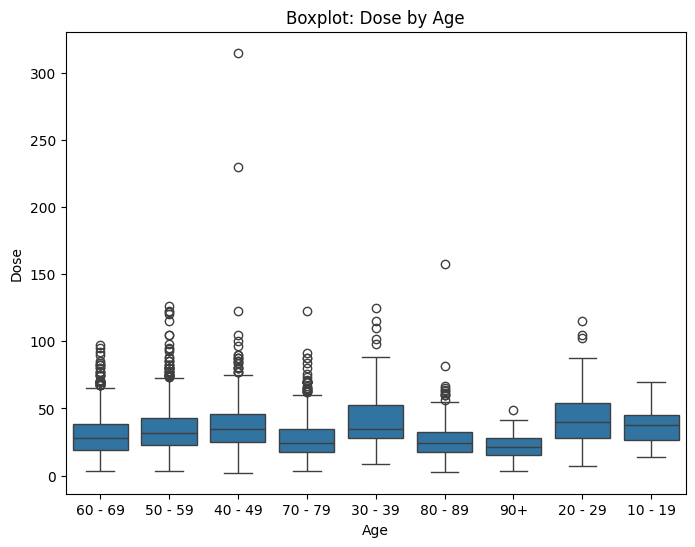

In [ ]:
#Dose by Age
plt.figure(figsize=(8,6))
sns.boxplot(x='Age', y='Dose', data=df)
plt.title('Boxplot: Dose by Age')
plt.show()

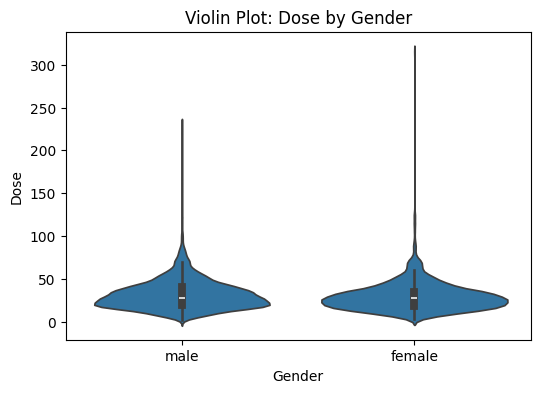

In [ ]:
#Dose by Gender
plt.figure(figsize=(6,4))
sns.violinplot(x='Gender', y='Dose', data=df)
plt.title('Violin Plot: Dose by Gender')
plt.show()

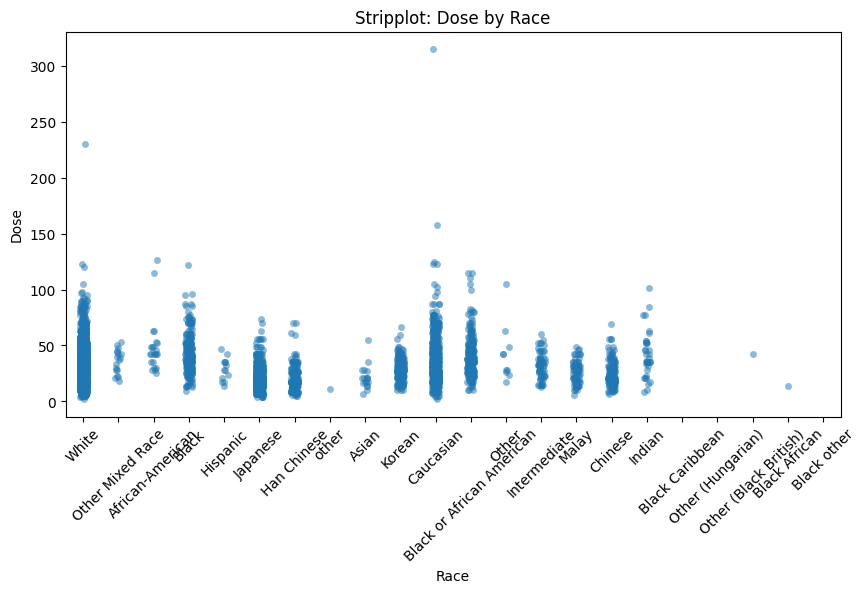

In [ ]:
#Dose by Race
plt.figure(figsize=(10,5))
sns.stripplot(x='Race', y='Dose', data=df, jitter=True, alpha=0.5, )
plt.title('Stripplot: Dose by Race')
plt.xticks(rotation=45)
plt.show()

# Step 5: Train-Test Split

In [ ]:
X = df_encoded.drop('Dose', axis=1)
y = df_encoded['Dose']

# Initial Train-Test Split → 70% Train, 30% Temporary (Val + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split Temporary into Validation and Test → 15% each
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Shapes for confirmation
print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Train set: (3990, 59)
Validation set: (855, 59)
Test set: (855, 59)


In [ ]:
# Drop NaNs in target & align X accordingly (train/val/test)
for dataset in [('train', X_train, y_train), ('val', X_val, y_val), ('test', X_test, y_test)]:
    name, X_df, y_df = dataset
    valid_idx = y_df.dropna().index
    if name == 'train':
        X_train, y_train = X_df.loc[valid_idx], y_df.loc[valid_idx]
    elif name == 'val':
        X_val, y_val = X_df.loc[valid_idx], y_df.loc[valid_idx]
    else:
        X_test, y_test = X_df.loc[valid_idx], y_df.loc[valid_idx]

# Apply log(1+x) transformation to y
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)


# Step 6: Model Training and Evaluation

In [ ]:
#Define Evaluation Function

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    # Train on Training Data (log-transformed target)
    model.fit(X_train, np.log1p(y_train))

    # Predict on Validation Set (reverse log-transform predictions)
    y_val_pred = np.expm1(model.predict(X_val))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)

    # Predict on Test Set (for final reporting)
    y_test_pred = np.expm1(model.predict(X_test))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"--- {model_name} ---")
    print(f"Validation → MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}, R2: {val_r2:.2f}")
    print(f"Test       → MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}")

    # Plot Actual vs Predicted (Test Set)
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_test_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Dose')
    plt.ylabel('Predicted Dose')
    plt.title(f'{model_name} - Test Set: Actual vs Predicted')
    plt.grid(True)
    plt.show()

    return {'Model': model_name, 'Val_MAE': val_mae, 'Val_RMSE': val_rmse, 'Val_R2': val_r2,
            'Test_MAE': test_mae, 'Test_RMSE': test_rmse, 'Test_R2': test_r2}


--- Linear Regression ---
Validation → MAE: 9.05, RMSE: 15.58, R2: 0.31
Test       → MAE: 8.22, RMSE: 11.67, R2: 0.43


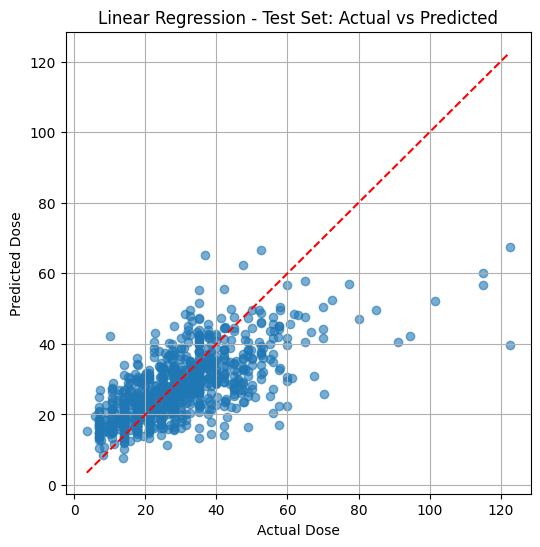

--- Lasso Regression ---
Validation → MAE: 11.38, RMSE: 18.24, R2: 0.05
Test       → MAE: 10.70, RMSE: 14.76, R2: 0.09


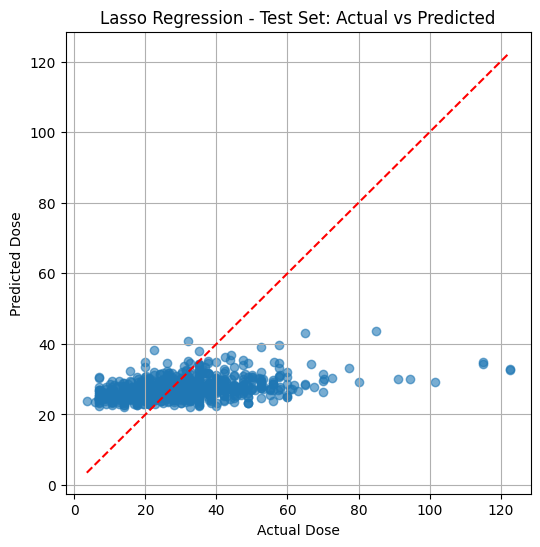

--- Random Forest ---
Validation → MAE: 9.78, RMSE: 16.36, R2: 0.23
Test       → MAE: 8.84, RMSE: 12.50, R2: 0.35


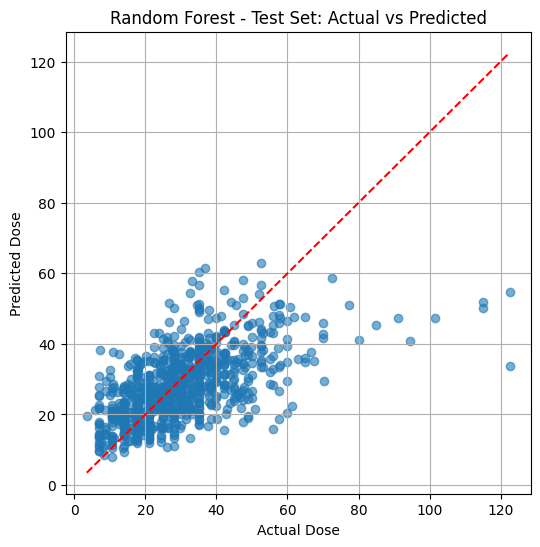

--- SVR ---
Validation → MAE: 12.26, RMSE: 19.38, R2: -0.07
Test       → MAE: 11.09, RMSE: 15.16, R2: 0.04


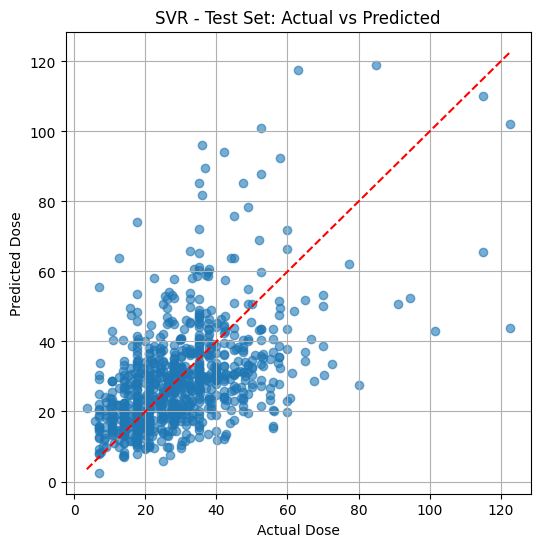

--- XGBoost ---
Validation → MAE: 9.13, RMSE: 15.89, R2: 0.28
Test       → MAE: 8.31, RMSE: 11.81, R2: 0.42


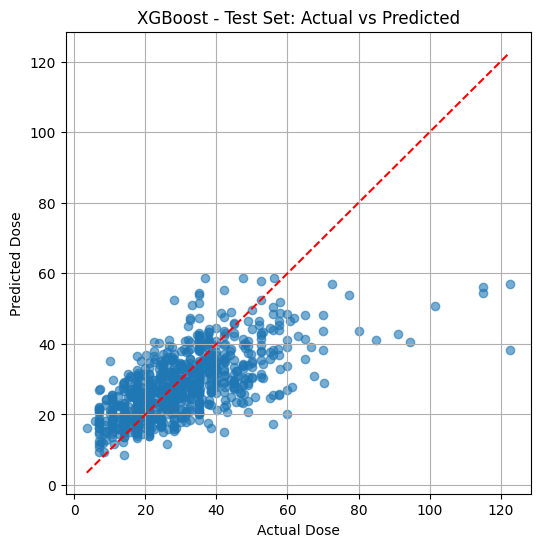

In [ ]:
# Train Multiple Models & Evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(C=100, epsilon=0.2),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
}

results = []
for name, model in models.items():
    result = evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, name)
    results.append(result)


In [ ]:
# Summary Table of Results
results_df = pd.DataFrame(results)
print(results_df[['Model', 'Val_MAE', 'Val_RMSE', 'Val_R2', 'Test_MAE', 'Test_RMSE', 'Test_R2']])


               Model    Val_MAE   Val_RMSE    Val_R2   Test_MAE  Test_RMSE  \
0  Linear Regression   9.049667  15.578633  0.305608   8.222339  11.671700   
1   Lasso Regression  11.380710  18.237167  0.048386  10.697746  14.758793   
2      Random Forest   9.776203  16.358337  0.234361   8.837424  12.501361   
3                SVR  12.260288  19.382298 -0.074871  11.088091  15.159118   
4            XGBoost   9.125310  15.891454  0.277441   8.308000  11.805780   

    Test_R2  
0  0.433403  
1  0.094042  
2  0.349989  
3  0.044228  
4  0.420310  


# Feature Selection & Dimensionality Reduction

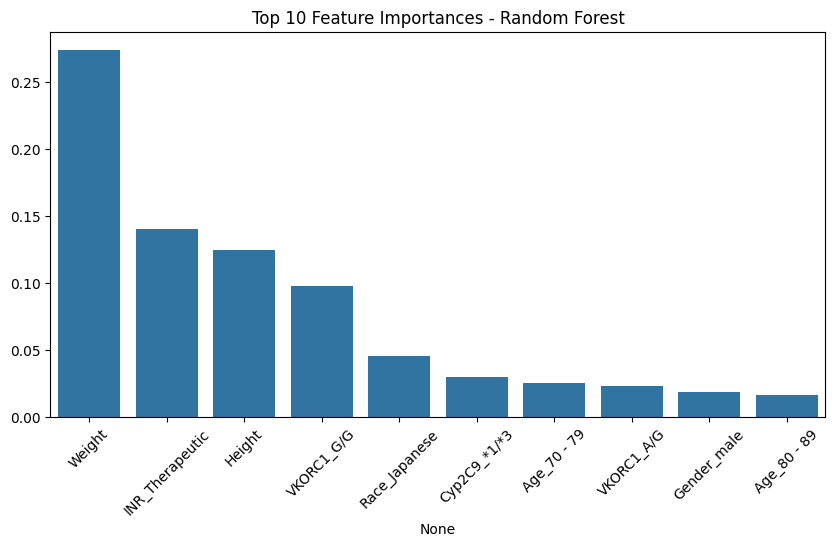

In [ ]:
# Random Forest Feature Importance
# Train RF model on train data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, np.log1p(y_train))

# Get Feature Importances
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

# Plot Top 10 Feature Importances
plt.figure(figsize=(10,5))
sns.barplot(x=X_train.columns[sorted_idx][:10], y=importances[sorted_idx][:10])
plt.title('Top 10 Feature Importances - Random Forest')
plt.xticks(rotation=45)
plt.show()


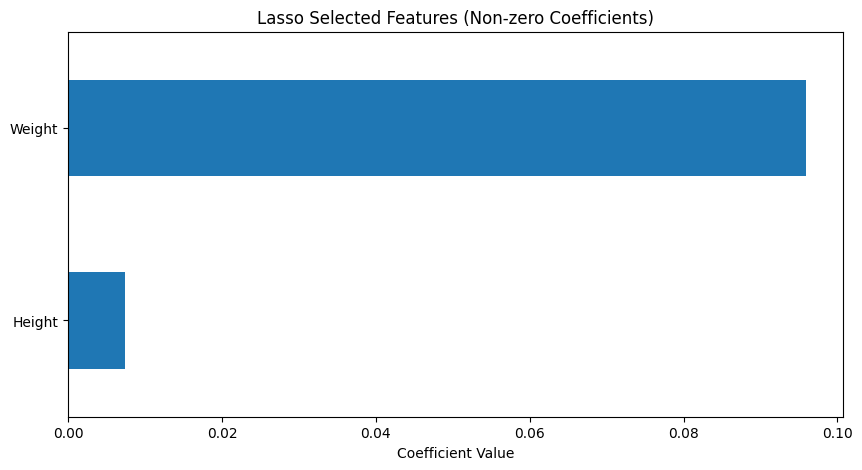

In [ ]:
# Lasso Regression for Feature Selection
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, np.log1p(y_train))

# Get coefficients
coef = pd.Series(lasso.coef_, index=X_train.columns)

# Plot non-zero coefficients (selected features)
selected_features = coef[coef != 0]

plt.figure(figsize=(10,5))
selected_features.sort_values().plot(kind='barh')
plt.title('Lasso Selected Features (Non-zero Coefficients)')
plt.xlabel('Coefficient Value')
plt.show()


# Step 7: Deep Learning Model (ANN)

In [ ]:
# ANN Model Architecture
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile Model
ann_model.compile(optimizer='adam', loss='mean_squared_error')

#Train ANN Model with Validation Set
history = ann_model.fit(
    X_train, np.log1p(y_train),
    validation_data=(X_val, np.log1p(y_val)),
    epochs=50, batch_size=32, verbose=0
)

# Predict on Test Set
y_test_pred_ann = np.expm1(ann_model.predict(X_test).flatten())

# Test Metrics
ann_mae = mean_absolute_error(y_test, y_test_pred_ann)
ann_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_ann))
ann_r2 = r2_score(y_test, y_test_pred_ann)

print(f"ANN (Test Set)\nMAE: {ann_mae:.2f} | RMSE: {ann_rmse:.2f} | R²: {ann_r2:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
ANN (Test Set)
MAE: 8.18 | RMSE: 11.58 | R²: 0.44


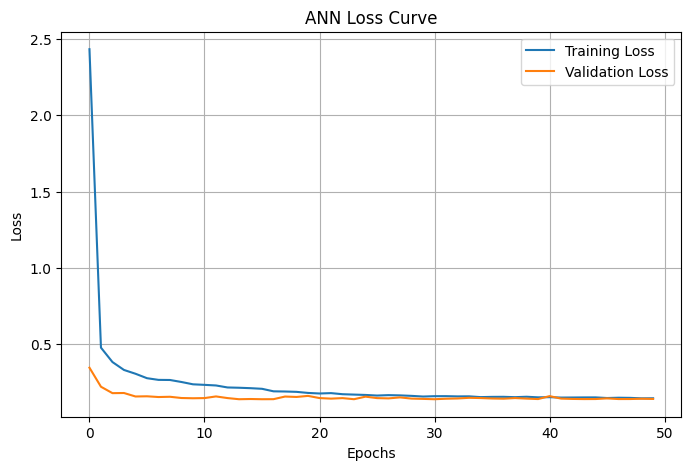

In [ ]:
#Plot Training & Validation Loss Curve
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ANN Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


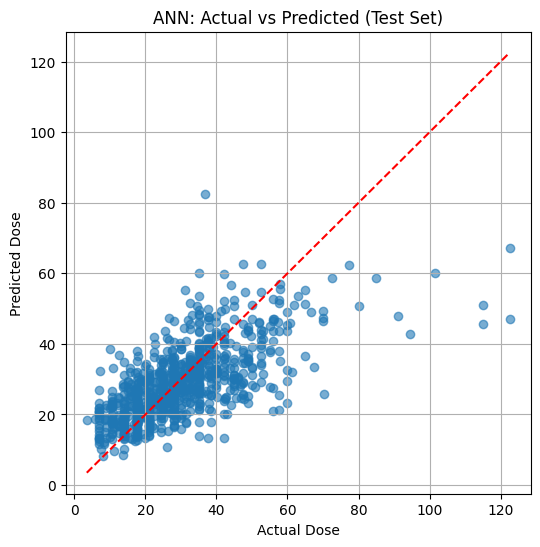

In [ ]:
#Plot Actual vs Predicted (Test Set)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred_ann, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Dose')
plt.ylabel('Predicted Dose')
plt.title('ANN: Actual vs Predicted (Test Set)')
plt.grid(True)
plt.show()


# Step 8:Model Saving

In [ ]:
# Combine Train + Validation data
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Retrain models for saving
models_top = {
    "Linear": LinearRegression(),
    "Lasso": Lasso(alpha=0.1),
    "Ridge": Ridge(alpha=1.0),
    "SVR": SVR(kernel='rbf', C=100, epsilon=0.2),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42),
}

for name, model in models_top.items():
    model.fit(X_train_full, np.log1p(y_train_full))
    joblib.dump(model, f"/content/{name.lower()}.pkl")
    print(f" Saved {name} model")

# Save ANN separately
ann_model.save("/content/final_model_ann.h5")
print(" Saved ANN model")


 Saved Linear model
 Saved Lasso model
 Saved Ridge model
 Saved SVR model
 Saved RandomForest model


 Saved XGBoost model
 Saved ANN model


# Step 9: Build Gradio App

In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00


In [ ]:
import gradio as gr
# Load saved models
models = {
    'Linear Regression': joblib.load("linear.pkl"),
    'Lasso Regression': joblib.load("lasso.pkl"),
    'Ridge Regression': joblib.load("ridge.pkl"),
    'SVR': joblib.load("svr.pkl"),
    'Random Forest': joblib.load("randomforest.pkl"),
    'XGBoost': joblib.load("xgboost.pkl"),
    'ANN': tf.keras.models.load_model("final_model_ann.h5")
}

# Prediction Function
def predict_dose(model_name, gender, race, age_group, height, weight, diabetes, simvastatin, amiodarone, target_inr, inr_therapeutic):
    # Prepare Input Data
    input_data = pd.DataFrame([{
        'Height': height,
        'Weight': weight,
        'Diabetes': diabetes,
        'Simvastatin': simvastatin,
        'Amiodarone': amiodarone,
        'Target_INR': target_inr,
        'INR_Therapeutic': inr_therapeutic,
        f'Gender_{gender}': 1,
        f'Race_{race}': 1,
        f'Age_{age_group}': 1
    }])

    # Ensure all necessary columns are present
    for col in X_train.columns:
        if col not in input_data.columns:
            input_data[col] = 0

    input_data = input_data[X_train.columns]

    # Predict log-transformed dose
    if model_name == 'ANN':
        log_pred = models[model_name].predict(input_data)[0][0]
    else:
        log_pred = models[model_name].predict(input_data)[0]

    # Convert back from log-scale
    predicted_dose = np.expm1(log_pred)
    return f"Predicted Dosage: {predicted_dose:.2f} mg/week"

# Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("## Warfarin Dose Prediction Tool")

    with gr.Row():
        with gr.Column():
            gender = gr.Dropdown(choices=["Male", "Female"], label="Gender")
            race = gr.Dropdown(choices=["Asian", "Black", "White", "Other"], label="Race")
            age_group = gr.Dropdown(choices=["20-29", "30-39", "40-49", "50-59", "60-69", "70-79"], label="Age Group")
            height = gr.Slider(100, 200, step=1, label="Height (cm)")
            weight = gr.Slider(30, 150, step=1, label="Weight (kg)")
            diabetes = gr.Radio(choices=[0, 1], label="Diabetes (0=No, 1=Yes)")
            simvastatin = gr.Radio(choices=[0, 1], label="Simvastatin (0=No, 1=Yes)")
            amiodarone = gr.Radio(choices=[0, 1], label="Amiodarone (0=No, 1=Yes)")
            target_inr = gr.Slider(1.0, 3.0, step=0.1, label="Target INR")
            inr_therapeutic = gr.Slider(0.5, 5.0, step=0.1, label="INR Therapeutic")

            model_name = gr.Dropdown(choices=list(models.keys()), label="Select Model")

        with gr.Column():
            output = gr.Textbox(label="Predicted Dose (mg/week)")

    predict_button = gr.Button("Predict")

    predict_button.click(
        fn=predict_dose,
        inputs=[model_name, gender, race, age_group, height, weight, diabetes, simvastatin, amiodarone, target_inr, inr_therapeutic],
        outputs=output
    )

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ee48f85be32a8ff9a2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
